Class=0, n=116, 54.717%
Class=2, n=29, 13.679%
Class=4, n=11, 5.189%
Class=3, n=23, 10.849%
Class=1, n=33, 15.566%


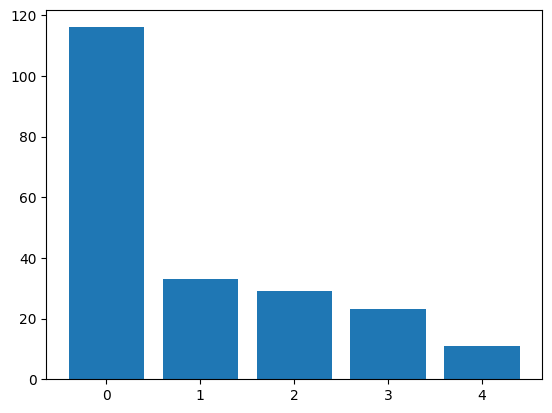

Before oversampling: Counter({0: 116, 1: 33, 2: 29, 3: 23, 4: 11})
After oversampling: Counter({0: 116, 2: 116, 4: 116, 3: 116, 1: 116})
LR Accuracy: 0.5824175824175825
[[35 13  1  0  0]
 [ 6  6  3  4  2]
 [ 0  0  5  1  1]
 [ 2  0  2  7  1]
 [ 0  0  1  1  0]]
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        49
           1       0.32      0.29      0.30        21
           2       0.42      0.71      0.53         7
           3       0.54      0.58      0.56        12
           4       0.00      0.00      0.00         2

    accuracy                           0.58        91
   macro avg       0.42      0.46      0.43        91
weighted avg       0.61      0.58      0.59        91

RF Accuracy: 0.5604395604395604
[[44  4  0  1  0]
 [11  3  3  3  1]
 [ 3  3  1  0  0]
 [ 1  4  3  3  1]
 [ 1  0  0  1  0]]
              precision    recall  f1-score   support

           0       0.73      0.90      0.81        49
           1       

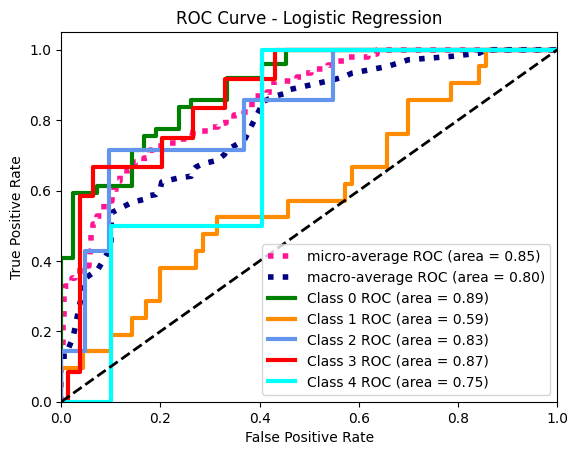

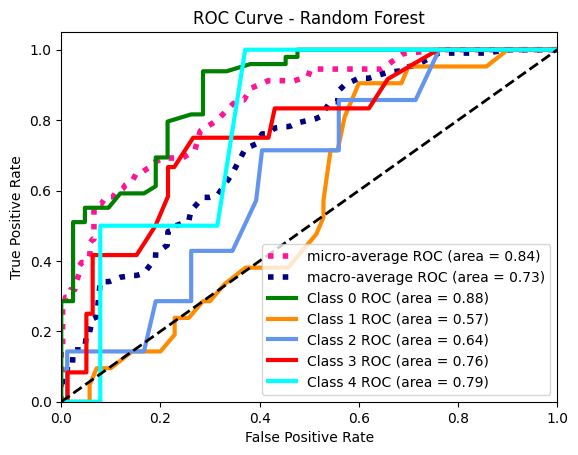

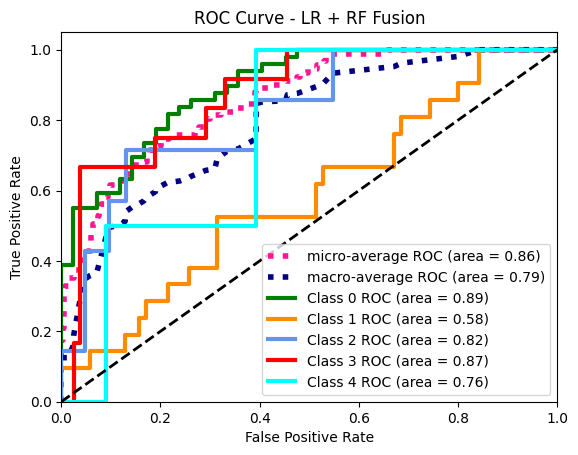

In [1]:
# Multi-class fusion model-3 (RF+LR) using weighted score fusion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# Load dataset
data = pd.read_csv("./multiclassification.csv")
X = data.iloc[:, 0:13].values
y = data.iloc[:, 13].values

# Train-test split (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Summarize class distribution
counter = Counter(y_train)
for k, v in counter.items():
    print(f"Class={k}, n={v}, {v/len(y_train)*100:.3f}%")
plt.bar(counter.keys(), counter.values())
plt.show()

# Oversampling
os = RandomOverSampler()
X_train_ns, y_train_ns = os.fit_resample(X_train, y_train)
print("Before oversampling:", Counter(y_train))
print("After oversampling:", Counter(y_train_ns))

X_train, y_train = X_train_ns, y_train_ns

# Standard & MinMax scalers
sc = StandardScaler()
scaler = MinMaxScaler(feature_range=(0,1))

# --- Logistic Regression ---
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
model_lr = LogisticRegression(C=0.1, max_iter=500)
model_lr.fit(X_train_scaled, y_train)

y_pred_lr = model_lr.predict(X_test_scaled)
predictions_lr = model_lr.predict_proba(X_test_scaled)
print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# --- Random Forest ---
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
predictions_rf = model_rf.predict_proba(X_test)
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# --- Weighted fusion ---
p_values = np.arange(1.0, 0, -0.05)
best_score = 0
best_p = 0
best_out = None

for p in p_values:
    q = 1 - p
    mixed = predictions_lr * p + predictions_rf * q
    out = np.argmax(mixed, axis=1)
    score = accuracy_score(y_test, out)
    print(f"Fusion Accuracy | p={p:.2f}, q={q:.2f}: {score:.4f}")
    if score > best_score:
        best_score = score
        best_p = p
        best_out = out

# Use best p
p = best_p
q = 1 - p
mixed = predictions_lr * p + predictions_rf * q
out = np.argmax(mixed, axis=1)
print("Final Fusion Accuracy:", accuracy_score(y_test, out))
print(confusion_matrix(y_test, out))
print(classification_report(y_test, out))

# --- ROC curves ---
n_classes = 5
y_test_bin = label_binarize(y_test, classes=range(n_classes))

def plot_multiclass_roc(y_test_bin, y_score, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=4, color='deeppink', label=f'micro-average ROC (area = {roc_auc["micro"]:.2f})')
    plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=4, color='navy', label=f'macro-average ROC (area = {roc_auc["macro"]:.2f})')

    colors = cycle(['green', 'darkorange', 'cornflowerblue','red','aqua'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=3, label=f'Class {i} ROC (area = {roc_auc[i]:.2f})')

    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC for each model and fusion
plot_multiclass_roc(y_test_bin, predictions_lr, "ROC Curve - Logistic Regression")
plot_multiclass_roc(y_test_bin, predictions_rf, "ROC Curve - Random Forest")
plot_multiclass_roc(y_test_bin, mixed, "ROC Curve - LR + RF Fusion")
